# Проект для «Викишоп» c BERT

**Описание проекта**  
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 

In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import os

import pandas as pd
import matplotlib as plt
import numpy as np

import re
import tqdm
import time 
from tqdm import notebook

import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

STOPWORDS = set(nltk_stopwords.words('english'))
RANDOM_STATE=42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Учеба\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Учеба\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!pip install transformers
import transformers

In [4]:
!pip install torch
import torch

In [5]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [6]:
!pip install lightgbm
from lightgbm import LGBMClassifier

### Обзор данных

In [7]:
if os.path.exists('/datasets/toxic_comments.csv'):
    data = pd.read_csv('/datasets/toxic_comments.csv')
else:
    data = pd.read_csv(r'C:\Users\Учеба\Desktop\anaconda\wikishop\toxic_comments.csv')

In [8]:
#data = pd.read_csv(r'C:\Users\Учеба\Desktop\anaconda\wikishop\toxic_comments.csv')

In [9]:
def data_class_info(data, target):
    """ 
    Осмотреть основную информацию о данных 
    """
    display(
        print('Дубликатов:', data.duplicated().sum()),
        print('Пропусков:', data.isna().sum()),
        print('  '),
        data.info(),
        print('  '),
        data[target].value_counts(),
        data[target].value_counts().plot(title='распределение классов',
                                         kind='pie',
                                         autopct='%1.0f%%',
                                         explode=(0.05, 0.05),
                                         colors=['DarkSeaGreen', 'LightCoral'],
                                         ylabel=' ',
                                         labels=[' ', 'toxic']
                                         #color='grey'
                                        ),
        data.head(5)
    )

Дубликатов: 0
Пропусков: Unnamed: 0    0
text          0
toxic         0
dtype: int64
  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
  


None

None

None

None

None

toxic
0    143106
1     16186
Name: count, dtype: int64

<Axes: title={'center': 'распределение классов'}, ylabel=' '>

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


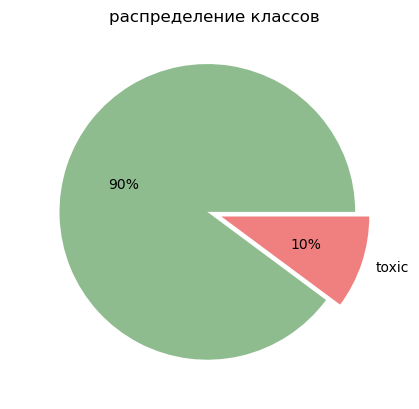

In [10]:
data_class_info(data, target='toxic')

**Промежуточные выводы:**  

В данных классы не сбалансированы, нетоксичных комментариев на порядок больше - буду иметь это ввиду в дальнейшем.  
Язык текстов - английский.  
В текстах есть служебные символы.  

---

### Подготовка данных

In [11]:
data = data.drop(['Unnamed: 0'], axis=1)

In [12]:
def preprocess_text(texts):
    """ 
    Приведение текста к нижнему регистру,
    удаление стоп-слов, лишних символов
    """
    stop_words = STOPWORDS
    regex = re.compile('[^a-z A-Z]')
    preprocess_texts = []
    for i in  tqdm.tqdm(range(len(texts))):
        text = texts[i].lower()
        text = regex.sub(' ', text)
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        preprocess_texts.append( ' '.join(filtered_sentence))

    return preprocess_texts             

In [13]:
%%time

data['processed'] = preprocess_text(data['text'])

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [00:26<00:00, 6072.66it/s]


CPU times: total: 26.2 s
Wall time: 26.2 s


In [14]:
data.head(10)

,text,toxic,processed
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations well use tools well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intending...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


Проведу стемминг полученного текста:

In [15]:
from nltk.stem.lancaster import LancasterStemmer

In [16]:
def stemming_texts(texts, st=None):
    st = LancasterStemmer() if st is None else st
    stem_text = []
    for text in tqdm.tqdm(texts):
        word_tokens = word_tokenize(text)
        stem_text.append(' '.join([st.stem(word) for word in word_tokens]))
    return stem_text

In [17]:
%%time

data['stemmed'] = stemming_texts(data['processed'])

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [01:14<00:00, 2142.71it/s]

CPU times: total: 1min 14s
Wall time: 1min 14s




Так как текст английский, попробую обучить модели еще на лемматизированном тексте:

---

In [18]:
# new lemmatization (spacy)
!pip install spacy

In [19]:
import spacy
spacy.cli.download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [21]:
def lemmatize_dataframe(texts):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    lemmatized_texts = []
    for text in tqdm.tqdm(texts):
        doc = nlp(text)
        lemmatized_text = " ".join([token.lemma_ for token in doc])
        lemmatized_texts.append(lemmatized_text)
    
    return lemmatized_texts

In [22]:
%%time

data['lemmatized_spacy'] = lemmatize_dataframe(data['processed'])

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [07:01<00:00, 377.69it/s]


CPU times: total: 7min 2s
Wall time: 7min 2s


In [23]:
data.head(5)

,text,toxic,processed,stemmed,lemmatized_spacy
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...,expl edit mad usernam hardc metallic fan rever...,explanation edit make username hardcore metall...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...,aww match background colo seem stuck thank tal...,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...,hey man real try edit war guy const remov rele...,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...,mak real suggest improv wond sect stat lat sub...,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page,sir hero chant rememb pag,sir hero chance remember page


---

**Промежуточный вывод:**  
Была проведена обработка текста, в оригинальный датасет добавлены два новых столбца для обучения на них моделей.

---

### Обучение моделей

1. Для создания матриц из данных использую TFIDF+BoW и BERT   
2. Обучу на них модели
3. Сравню их результы на тренировочных данных между собой
4. Модель с лучшим результатом проверю на тестовых данных.

По заданию метрика f1_score

Разделю на train, valid и test:

In [24]:
train, test = train_test_split(data, test_size=0.4,
                                random_state = RANDOM_STATE,
                                stratify = data['toxic'])

In [25]:
display(train.shape,
        train['toxic'].value_counts(normalize=True),
        test.shape,
        test['toxic'].value_counts(normalize=True))

(95575, 5)

toxic
0    0.898383
1    0.101617
Name: proportion, dtype: float64

(63717, 5)

toxic
0    0.898394
1    0.101606
Name: proportion, dtype: float64

#### Bag of Words & TF IDF

In [26]:
vectorizer = CountVectorizer()

In [27]:
vectorizer_tf_idf = TfidfVectorizer()

In [28]:
def bow(vectorizer, train, test):
    """
    Составить матрицы для train и test BoW
    """
    train_bow = vectorizer.fit_transform(train)
    test_bow = vectorizer.transform(test)
    return train_bow, test_bow

In [29]:
train_tfidf_stemmed, test_tfidf_stemmed = bow(vectorizer_tf_idf,
                                              train['stemmed'],
                                              test['stemmed'],
                                                           )

In [30]:
display(
    train_tfidf_stemmed.shape,
    test_tfidf_stemmed.shape
)

(95575, 82282)

(63717, 82282)

In [31]:
train_tfidf_lemmatized, test_tfidf_lemmatized = bow(vectorizer_tf_idf,
                                                    train['lemmatized_spacy'],
                                                    test['lemmatized_spacy'],
                                                           )

In [32]:
display(
    train_tfidf_lemmatized.shape,
    test_tfidf_lemmatized.shape
)

(95575, 113648)

(63717, 113648)



**Промежуточный вывод:**  
Данные разделены на обучающую и тестовую выборки, проведено преобразование данных в матрицы BoW+TFIDF

---

#### Обучение моделей на TFIDF+BoW

Буду обучать следующие модели:  

0. DummyClassifier - для сравнения результатов
1. LinearSVC
2. LogisticRegression
3. LightGBM


##### DummyClassifier

In [33]:
results=[]

In [34]:
# stemmed
clf = DummyClassifier(random_state=RANDOM_STATE)

start = time.time()
clf.fit(train_tfidf_stemmed, train['toxic'])
end = time.time()
time_fit = end - start

dummy_predict = clf.predict(test_tfidf_stemmed)
dummy_f1 = f1_score(dummy_predict, test['toxic'])

results.append(['dummy', time_fit, dummy_f1])

##### LinearSVC

In [35]:
clf_svc = LinearSVC()

In [36]:
parameters = [{'penalty': ['l1', 'l2']}, 
              {'C': [1, 5, 10, 15]}]

# stemmed
grid_search = GridSearchCV(estimator=clf_svc,  
                           param_grid=parameters,
                           scoring='f1',
                           cv=5,
                           verbose=0)

In [37]:
grid_search.fit(train_tfidf_stemmed, train['toxic'])

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 5, 10, 15]}],
             scoring='f1')

In [38]:
grid_search.best_params_

{'penalty': 'l2'}

In [39]:
start = time.time()
clf_svc.fit(train_tfidf_stemmed, train['toxic'])
end = time.time()
time_fit = end - start

results.append(['LinearSVC_stemmed', time_fit, grid_search.best_score_])

In [40]:
# lemmatized
grid_search.fit(train_tfidf_lemmatized, train['toxic'])

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 5, 10, 15]}],
             scoring='f1')

In [41]:
start = time.time()
clf_svc.fit(train_tfidf_lemmatized, train['toxic'])
end = time.time()
time_fit = end - start

results.append(['LinearSVC_lemmatized', time_fit, grid_search.best_score_])

##### LogisticRegression

In [42]:
clf_log = LogisticRegression()

In [43]:
# stemmed
grid_search = GridSearchCV(estimator=clf_log,  
                           param_grid=parameters,
                           scoring='f1',
                           cv=5,
                           verbose=0)

In [44]:
grid_search.fit(train_tfidf_stemmed, train['toxic'])

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 5, 10, 15]}],
             scoring='f1')

In [45]:
grid_search.best_estimator_

LogisticRegression(C=10)

In [46]:
clf_log = LogisticRegression(C=10)
start = time.time()
clf_log.fit(train_tfidf_stemmed, train['toxic'])
end = time.time()
time_fit = end - start

In [47]:
results.append(['LogisticRegression_stemmed', time_fit, grid_search.best_score_])

In [48]:
# lemmatized
grid_search.fit(train_tfidf_lemmatized, train['toxic'])

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 5, 10, 15]}],
             scoring='f1')

In [49]:
grid_search.best_estimator_

LogisticRegression(C=15)

In [50]:
clf_log = LogisticRegression(C=15)
start = time.time()
clf_log.fit(train_tfidf_lemmatized, train['toxic'])
end = time.time()
time_fit = end - start

results.append(['LogisticRegression_lemmatized', time_fit, grid_search.best_score_])

##### LightGBM

In [51]:
clf_lgbm = LGBMClassifier()

In [52]:
# pipeline///

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('lgbm', LGBMClassifier()) 
])

pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lgbm', LGBMClassifier())])

In [53]:
param_grid = {
    'lgbm__n_estimators': [50, 100, 150],
    'lgbm__max_depth': [3, 5, 7],
    'lgbm__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = RandomizedSearchCV(pipeline,
                                 param_distributions=param_grid,
                                 scoring='f1',
                                 verbose=0)

In [54]:
train['stemmed'].shape

(95575,)

In [55]:
start = time.time()
grid_search.fit(train['stemmed'].head(50000), train['toxic'].head(50000))
end = time.time()
time_fit = end - start

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4100, number of negative: 35900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223222
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 3959
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102500 -> initscore=-2.169750
[LightGBM] [Info] Start training from score -2.169750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [56]:
display(grid_search.best_estimator_,
        grid_search.best_score_)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lgbm',
                 LGBMClassifier(learning_rate=0.2, max_depth=5,
                                n_estimators=150))])

0.7261981669020469

In [57]:
results.append(['LGBM_stemmed', time_fit, grid_search.best_score_])

---
Посмотрю на предварительные результаты:

In [58]:
pd.DataFrame(results, columns=['model', 'time_fit', 'f1_score']).sort_values(by=['f1_score'], ascending=False)

,model,time_fit,f1_score
2,LinearSVC_lemmatized,0.313457,0.775822
1,LinearSVC_stemmed,0.301598,0.769533
4,LogisticRegression_lemmatized,2.448646,0.768825
3,LogisticRegression_stemmed,2.022000,0.766552
5,LGBM_stemmed,135.988328,0.726198
0,dummy,0.002992,0.000000


**Промежуточный вывод:**

Несмотря на то, что тюнинг параметров не проводился, все модели смогли преодолеть необходимый порог f1 в 0.75 на кроссвалидации;  
Есть небольшая разница в результатах моделей, обучавшихся на простеммированных и лемматизированных данных, но она не выглядит существенной;  
Лучший предварительный результат показывает LinearSVC, особенно если брать во внимание время обучения.

---

#### BERT

In [59]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [60]:
print('torch.cuda.is_available() ', torch.cuda.is_available())

torch.cuda.is_available()  True


In [61]:
print(torch.version.cuda)

11.8


In [62]:
# Использую GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using NVIDIA GeForce RTX 2060 GPUs


In [63]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

In [64]:
text = list(data['processed'])

In [65]:
tokenized = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

In [66]:
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [67]:
%%time

batch_size = 50
embeddings = []

for i in notebook.tqdm(range(tokenized['input_ids'].shape[0] // batch_size)):
    
        tokens = tokenized['input_ids'][batch_size*i:batch_size*(i+1)]
        token_types = tokenized['token_type_ids'][batch_size*i:batch_size*(i+1)]
        mask = tokenized['attention_mask'][batch_size*i:batch_size*(i+1)]
        
        batch = {'input_ids' : tokens.to(device),
                 'token_type_ids' : token_types.to(device), 
                 'attention_mask' : mask.to(device)}
                
        with torch.no_grad():
            batch_embeddings = model(**batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy())
        
torch.cuda.empty_cache()

  0%|          | 0/3185 [00:00<?, ?it/s]

CPU times: total: 1h 1min 20s
Wall time: 1h 1min 20s


In [68]:
len(embeddings)

3185

Получение эмбеддингов заняло 1 час 1 минуту. Разделю данные на train и test:

In [69]:
features = np.concatenate(embeddings)
target = data['toxic'][0:159250]

In [70]:
features_train_bert, features_test_bert, target_train_bert, target_test_bert = train_test_split(features,
                                                                            target,
                                                                            test_size=0.4,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target)

In [71]:
display(features_train_bert.shape,
        target_train_bert.value_counts(normalize=True),
        features_test_bert.shape,
        target_test_bert.value_counts(normalize=True)
        )

(95550, 768)

toxic
0    0.898378
1    0.101622
Name: proportion, dtype: float64

(63700, 768)

toxic
0    0.898383
1    0.101617
Name: proportion, dtype: float64

##### Обучение модели

Буду обучать логистическую регрессию

In [78]:
clf_bert = LogisticRegression(C=10)

In [79]:
start = time.time()
clf_bert.fit(features_train_bert, target_train_bert)
end = time.time()
time_fit = end - start

scores = cross_val_score(clf_bert, features_train_bert, target_train_bert, cv=5, scoring='f1')

results.append(['LogisticRegression_BERT', time_fit, scores.mean()])

In [74]:
pd.DataFrame(results, columns=['model', 'time_fit', 'f1_score']).sort_values(by=['f1_score'], ascending=False)

,model,time_fit,f1_score
6,LogisticRegression_BERT,5.801069,0.867082
2,LinearSVC_lemmatized,0.313457,0.775822
1,LinearSVC_stemmed,0.301598,0.769533
4,LogisticRegression_lemmatized,2.448646,0.768825
3,LogisticRegression_stemmed,2.022000,0.766552
5,LGBM_stemmed,135.988328,0.726198
0,dummy,0.002992,0.000000


**Промежуточный вывод:**  
Обученная на матрице BERT модель справляется с задачей классификации текстов лучше классических, но и обучается дольше. Создание эмбеддингов занимает значительное время (почти час используя gpu).  

---

### Тестирование модели

Так как по заданию важна именно метрика f1, для финального тестирования буду использовать модель c BERT.  

In [80]:
print('f1_score финальной модели на тестовых данных: ', f1_score(clf_bert.predict(features_test_bert), target_test_bert))
print('f1_score dummy на тестовых данных: ', f1_score(clf.predict(test_tfidf_stemmed), test['toxic']))

f1_score финальной модели на тестовых данных:  0.8670191776497514
f1_score dummy на тестовых данных:  0.0


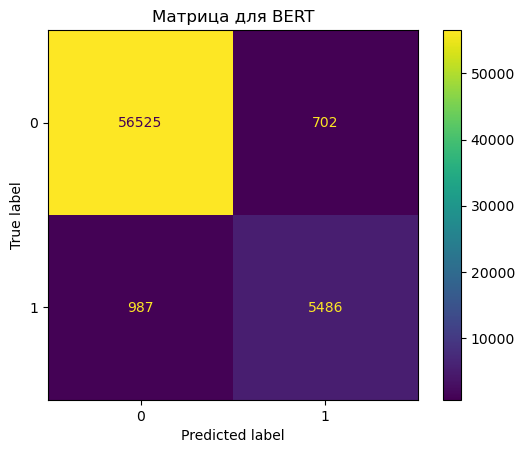

In [76]:
cm = confusion_matrix(target_test_bert, clf_bert.predict(features_test_bert))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
disp.ax_.set_title('Матрица для BERT');

### Вывод

**Дано:** данные с разметкой о токсичности   
**Задача:** обучить модель для определения токсичных текстов  

---

Был проведен аналих и предобработка данных, затем создание матриц BoW для моделей.  
Были обучены несколько моделей классического машинного обучения, а так же одна с использованием BERT. В итоге наилучший результат был получен у BERT - f1_score почти 0.87 на тренировочных данных и 0.86 на тестовых.  
